In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

In [3]:
from src.data_processing import (get_LFP_dataframe, make_tetrode_dataframe,
                                 make_tetrode_pair_info, reshape_to_segments)
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES, ALPHA)
from src.analysis import (decode_ripple_clusterless,
                          detect_epoch_ripples, is_overlap,
                          _subtract_event_related_potential)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
epoch_key = ('HPa', 6, 2)

In [5]:
ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
tetrode_info = tetrode_info[
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]
tetrode_pair_info = make_tetrode_pair_info(tetrode_info)
lfps = {tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in tetrode_info.index}

In [6]:
from copy import deepcopy
from functools import partial, wraps

multitaper_parameter_name = '4Hz_Resolution'
multitaper_params = MULTITAPER_PARAMETERS[multitaper_parameter_name]
num_lfps = len(lfps)
num_pairs = int(num_lfps * (num_lfps - 1) / 2)
params = deepcopy(multitaper_params)
window_of_interest = params.pop('window_of_interest')
reshape_to_trials = partial(
    reshape_to_segments,
    sampling_frequency=params['sampling_frequency'],
    window_offset=window_of_interest, concat_axis=1)

ripple_locked_lfps = pd.Panel({
    lfp_name: _subtract_event_related_potential(
        reshape_to_trials(lfps[lfp_name], ripple_times))
    for lfp_name in lfps})

In [273]:
from src.spectral.connectivity import Connectivity
from src.spectral.transforms import Multitaper

m = Multitaper(
    np.rollaxis(ripple_locked_lfps.values, 0, 3),
    **params,
    start_time=ripple_locked_lfps.major_axis.min())
c = Connectivity(
        fourier_coefficients=m.fft(),
        frequencies=m.frequencies,
        time=m.time)

Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.25, time_window_step=0.25, detrend_type='constant', start_time=-0.75)


In [124]:
n_lfps = len(lfps)
ds = xr.Dataset(
    {'coherence_magnitude': (['time', 'frequency', 'tetrode1', 'tetrode2'], c.coherence_magnitude()),
     'pairwise_spectral_granger_prediction': (['time', 'frequency', 'tetrode1', 'tetrode2'], c.pairwise_spectral_granger_prediction())},
    coords={'time': c.time + np.diff(c.time)[0] / 2, 
            'frequency': c.frequencies + np.diff(c.frequencies)[0] / 2,
            'tetrode1': tetrode_info.tetrode_id.values,
            'tetrode2': tetrode_info.tetrode_id.values,
            'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
            'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
            'session': np.array(['{0}_{1:02d}_{2:02d}'.format(*epoch_key)]),
            }
)

ds

<xarray.Dataset>
Dimensions:                               (frequency: 188, session: 1, tetrode1: 19, tetrode2: 19, time: 5)
Coordinates:
  * session                               (session) <U9 'HPa_06_02'
  * time                                  (time) float64 -0.625 -0.375 ...
  * frequency                             (frequency) float64 2.0 6.0 10.0 ...
    brain_area1                           (tetrode1) <U4 'CA1' 'CA1' 'CA1' ...
  * tetrode1                              (tetrode1) object 'HPa621' ...
    brain_area2                           (tetrode2) <U4 'CA1' 'CA1' 'CA1' ...
  * tetrode2                              (tetrode2) object 'HPa621' ...
Data variables:
    pairwise_spectral_granger_prediction  (time, frequency, tetrode1, tetrode2) float64 0.0 ...
    coherence_magnitude                   (time, frequency, tetrode1, tetrode2) float64 nan ...

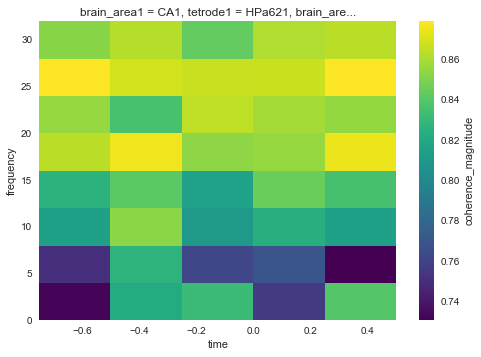

In [125]:
ds.sel(
    tetrode1='HPa621',
    tetrode2='HPa624',
    frequency=slice(0, 30)).coherence_magnitude.plot(x='time', y='frequency');

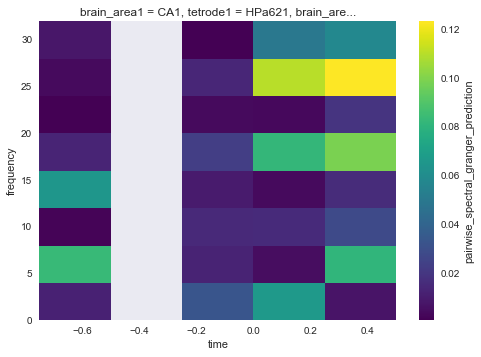

In [131]:
ds.sel(
    tetrode1='HPa621',
    tetrode2='HPa6220',
    frequency=slice(0, 30)
).pairwise_spectral_granger_prediction.plot(x='time', y='frequency');

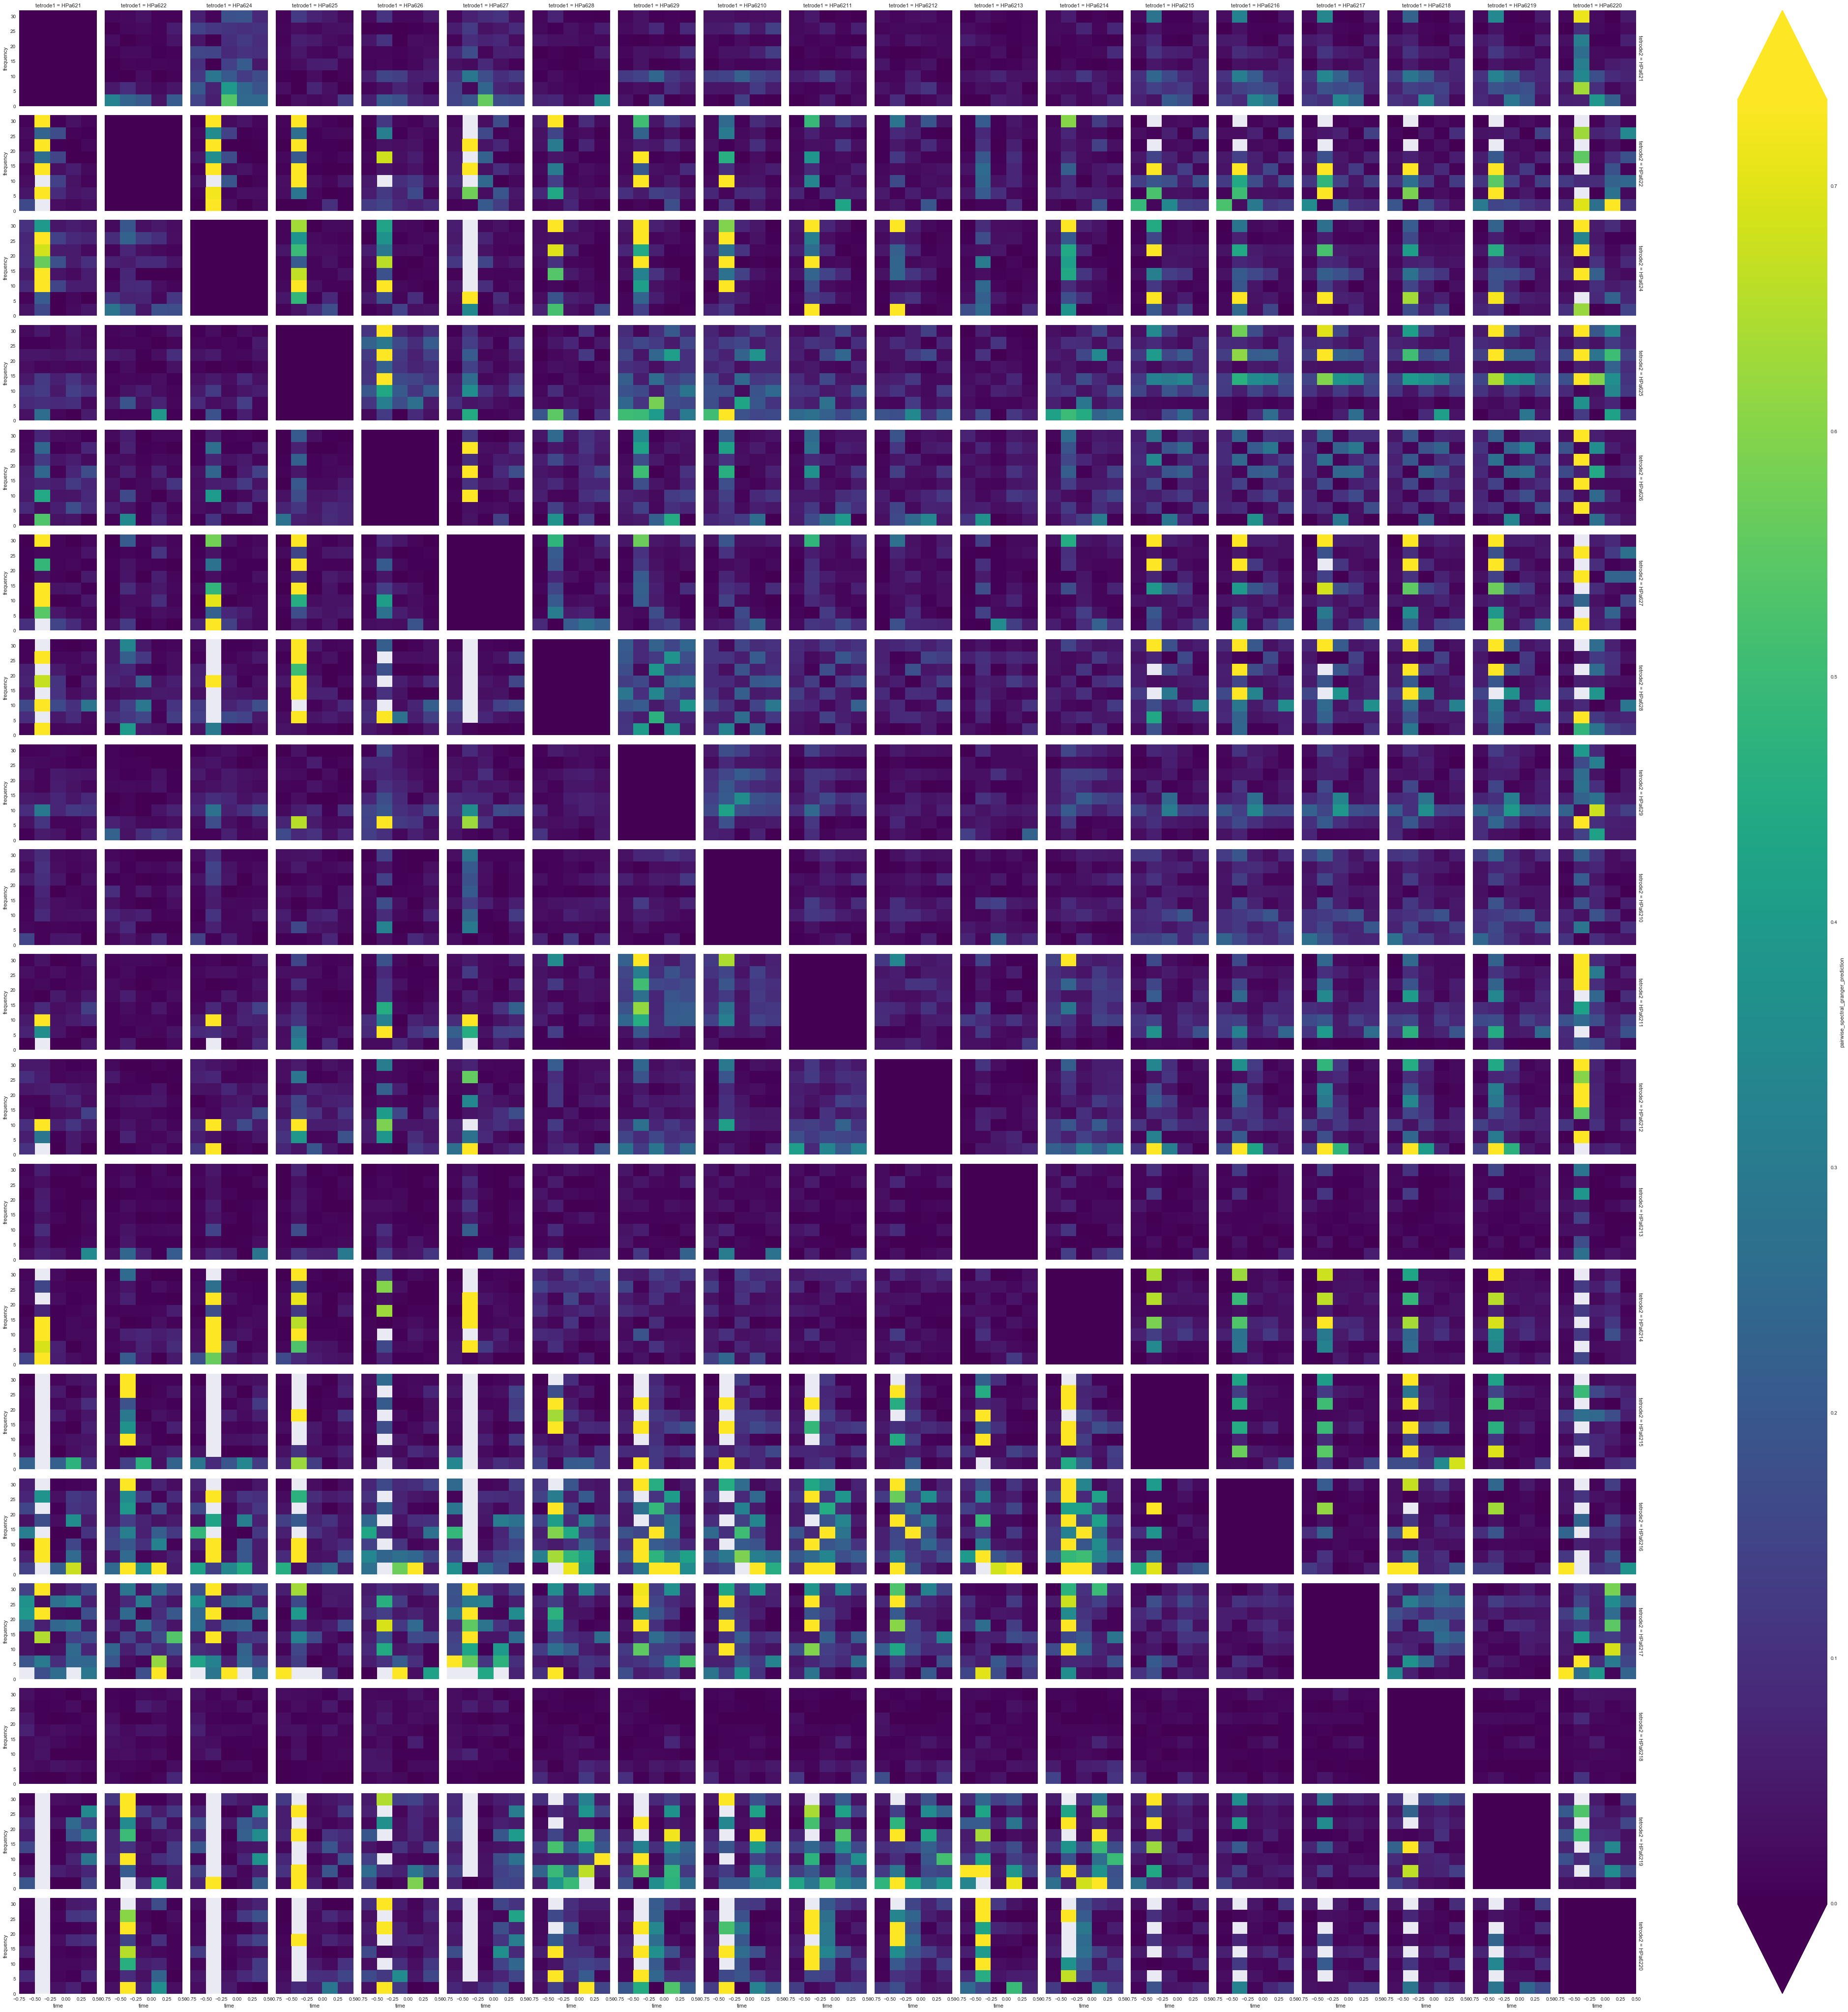

In [132]:
ds['pairwise_spectral_granger_prediction'].sel(
    frequency=slice(0, 30)).plot(x='time', y='frequency', col='tetrode1', row='tetrode2', robust=True);

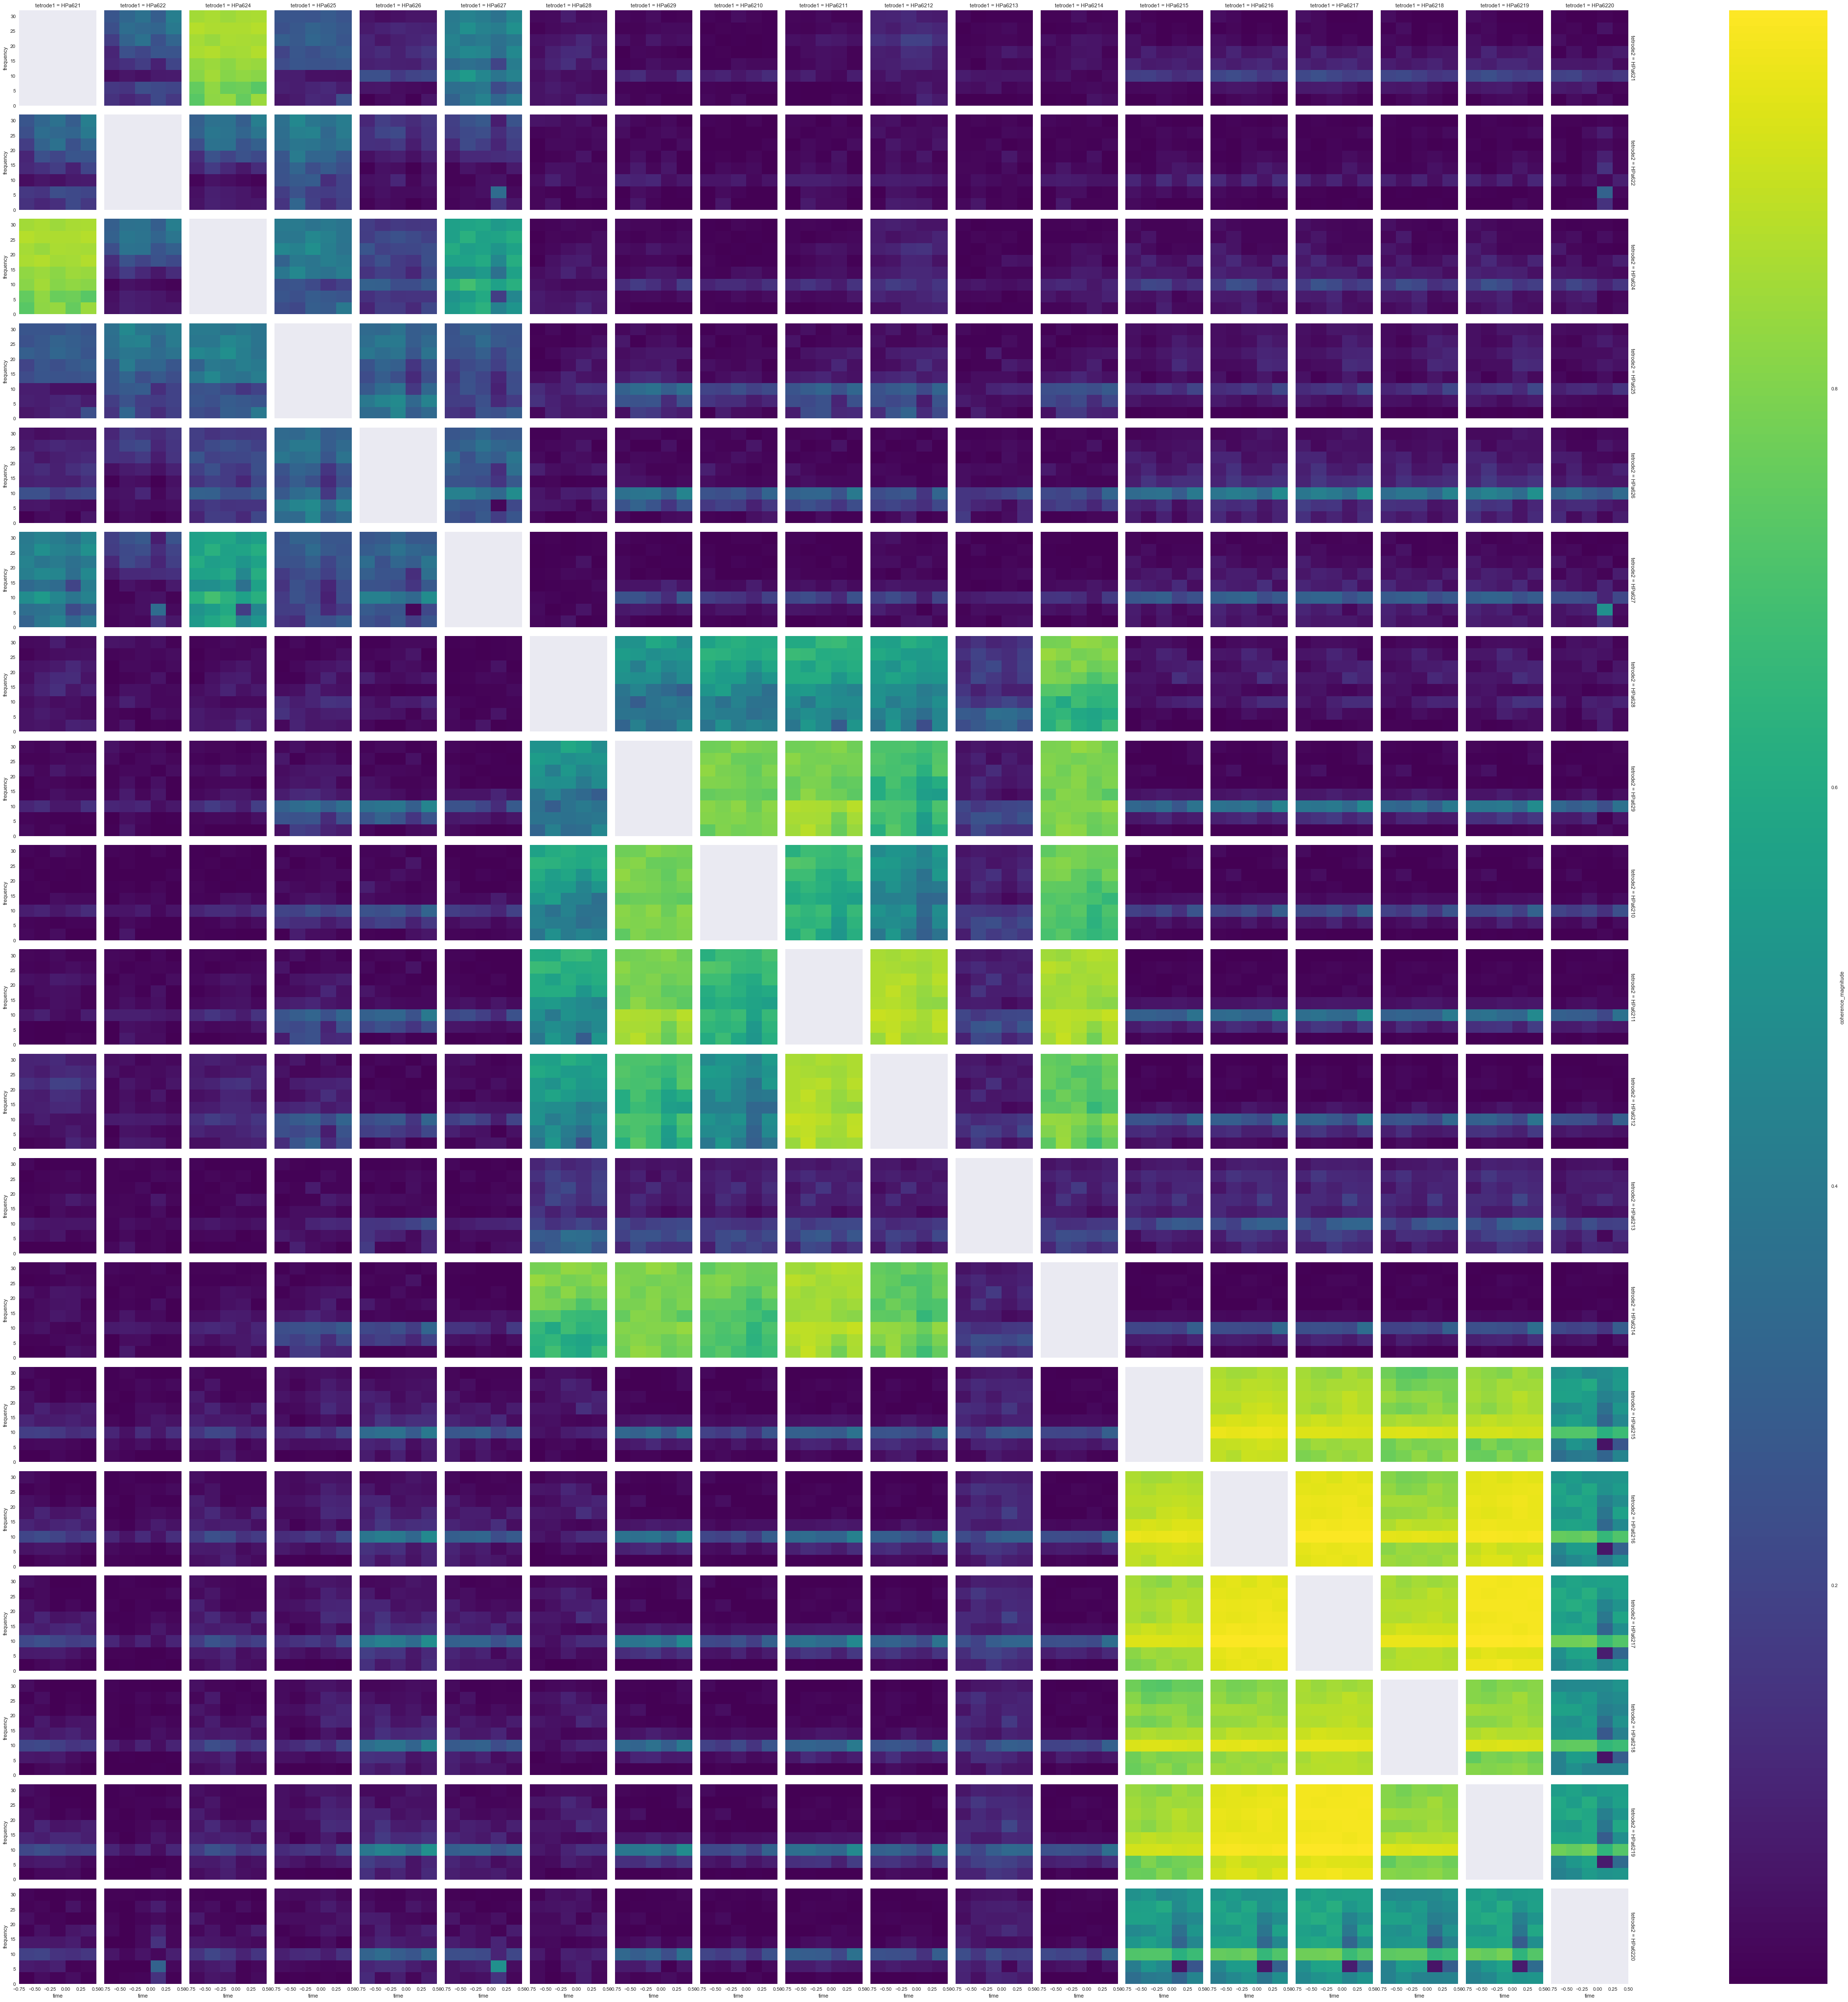

In [133]:
ds['coherence_magnitude'].sel(
    frequency=slice(0, 30)).plot(x='time', y='frequency', col='tetrode1', row='tetrode2');

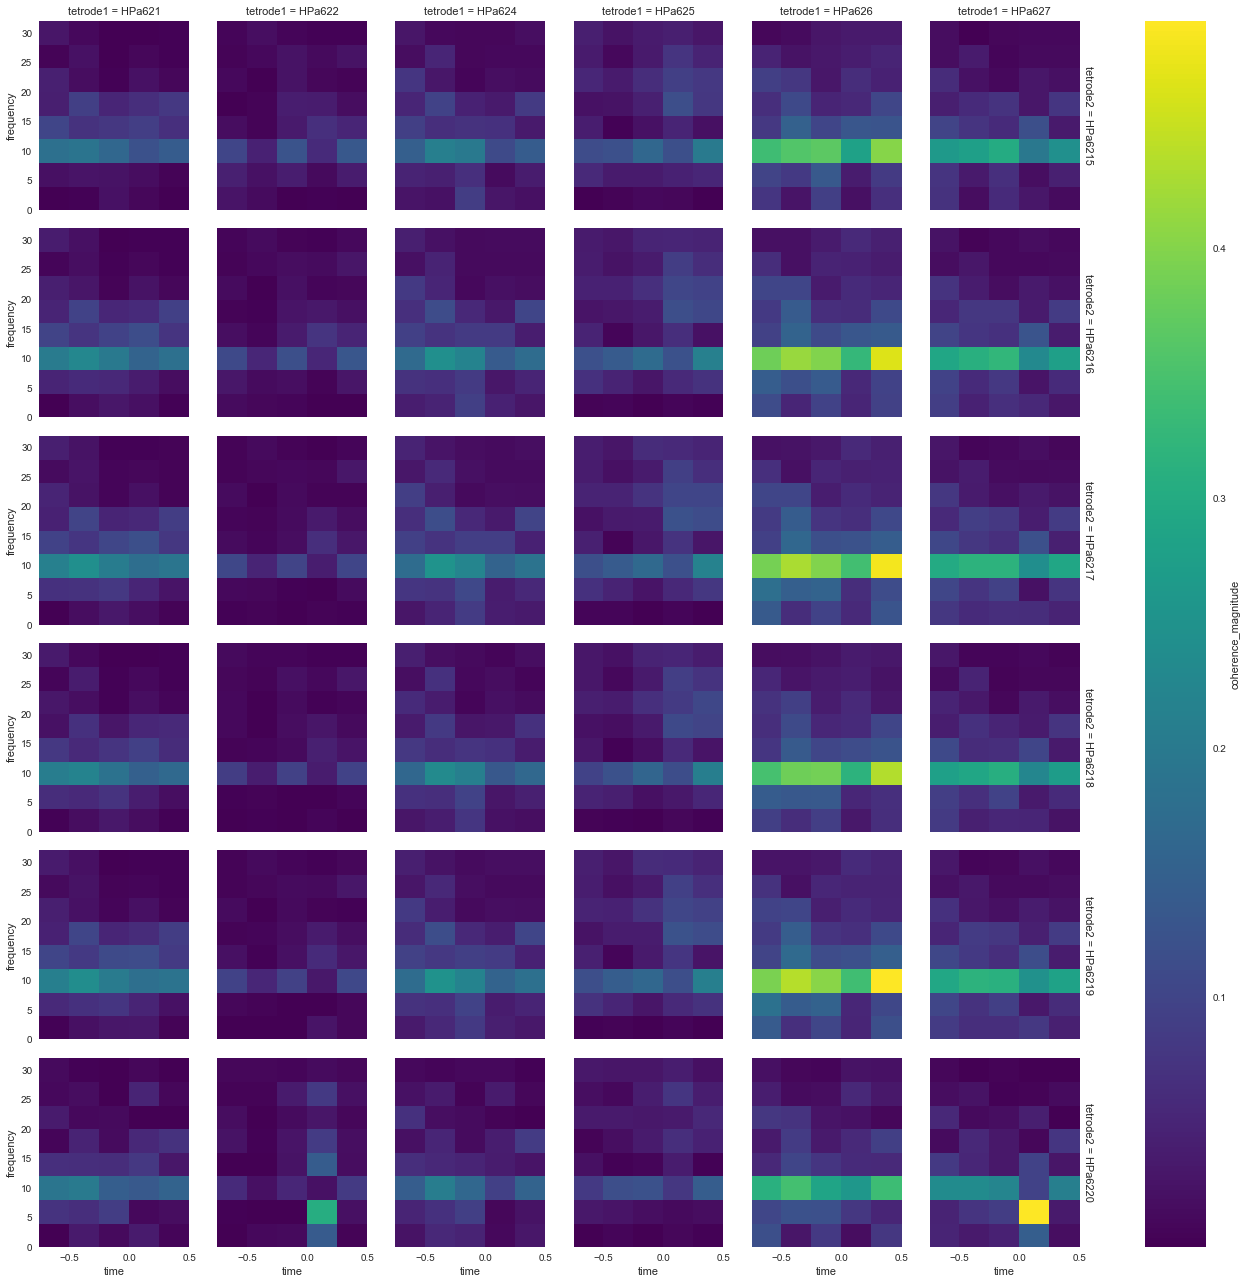

In [134]:
(ds.sel(
    tetrode1=ds.tetrode1[ds.brain_area1=='CA1'],
    tetrode2=ds.tetrode2[ds.brain_area2=='PFC'],
    frequency=slice(0, 30))
 .coherence_magnitude
 .plot(x='time', y='frequency', col='tetrode1', row='tetrode2'));

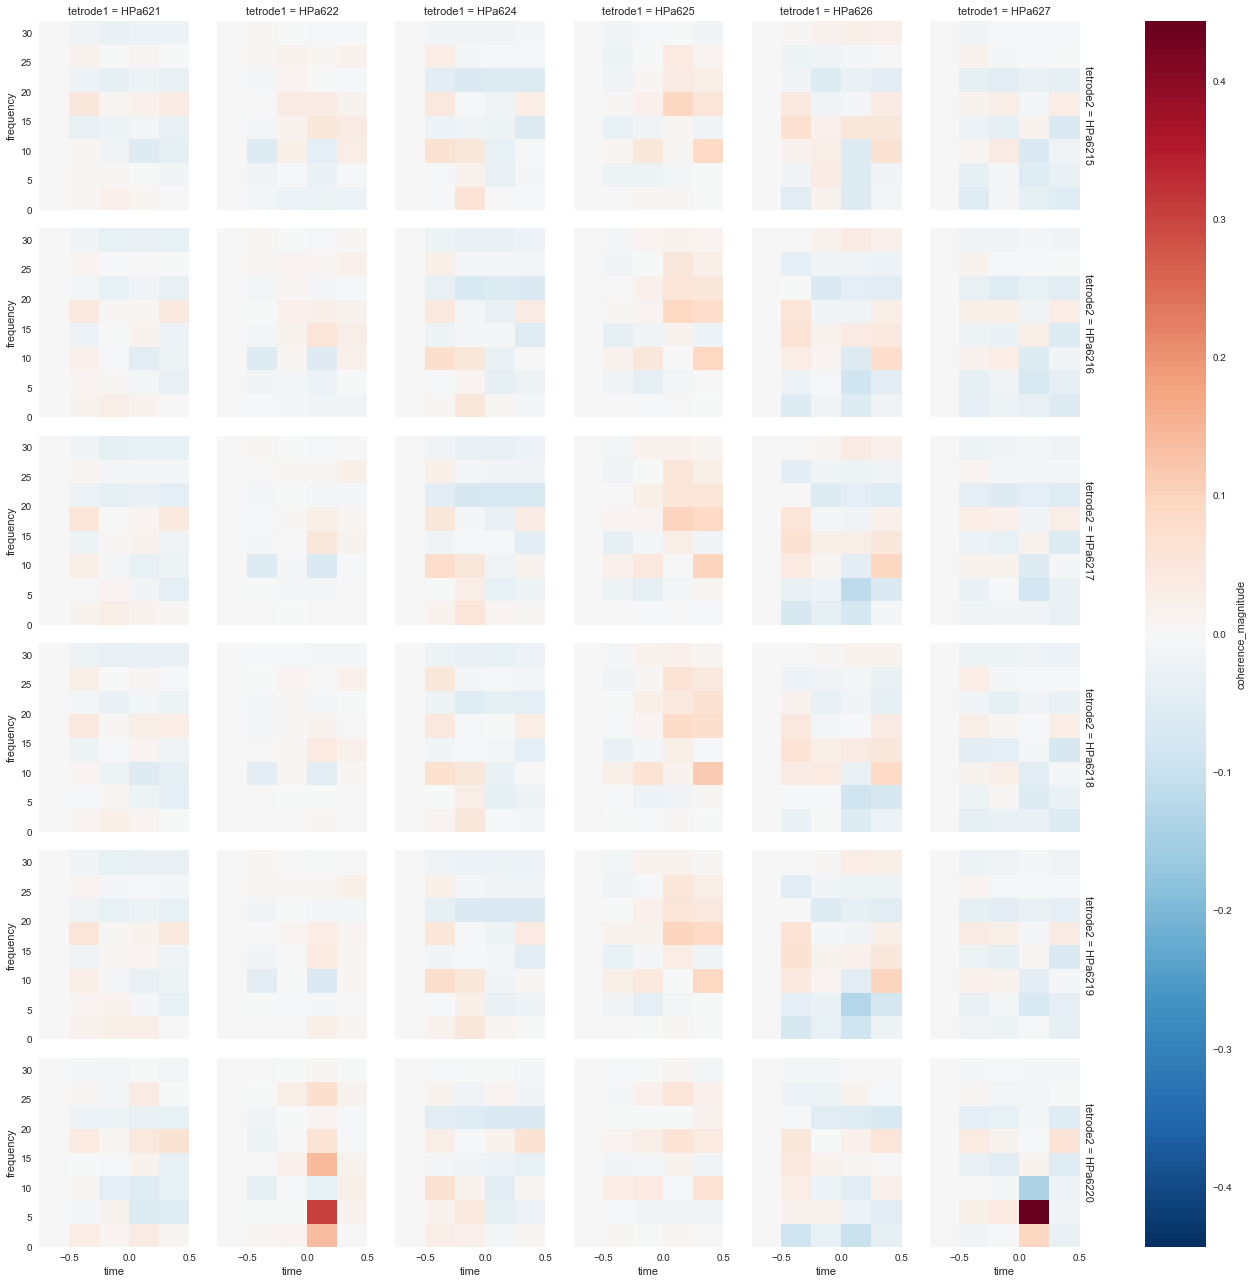

In [141]:
((ds - ds.isel(time=0)).sel(
    tetrode1=ds.tetrode1[ds.brain_area1=='CA1'],
    tetrode2=ds.tetrode2[ds.brain_area2=='PFC'],
    frequency=slice(0, 30))
 .coherence_magnitude
 .plot(x='time', y='frequency', col='tetrode1', row='tetrode2'));

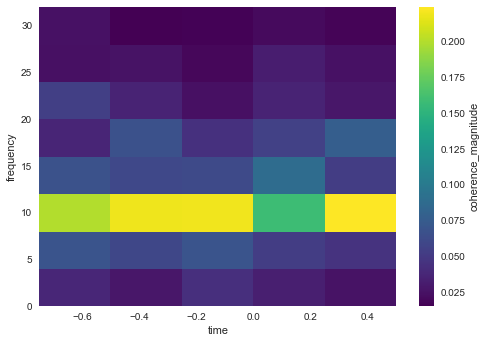

In [135]:
(ds.sel(
    tetrode1=ds.tetrode1[ds.brain_area1=='CA1'],
    tetrode2=ds.tetrode2[ds.brain_area2=='PFC'],
    frequency=slice(0, 30))
 .coherence_magnitude.mean(['tetrode1', 'tetrode2'])
 .plot(x='time', y='frequency'));

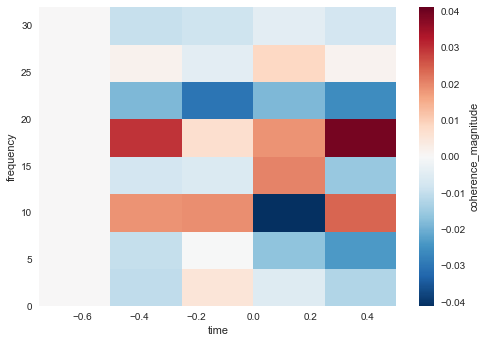

In [145]:
((ds - ds.isel(time=0)).sel(
    tetrode1=ds.tetrode1[ds.brain_area1=='CA1'],
    tetrode2=ds.tetrode2[ds.brain_area2=='PFC'],
    frequency=slice(0, 30))
 .coherence_magnitude.mean(['tetrode1', 'tetrode2'])
 .plot(x='time', y='frequency'));

In [99]:
import os

path = '{0}_{1:02d}_{2:02d}.nc'.format(*epoch_key)
group = '{0}/'.format(multitaper_parameter_name)
write_mode = 'a' if os.path.isfile(path) else 'w'
ds.to_netcdf(path=path, group=group, mode=write_mode)

In [173]:
with xr.open_dataset(path, group=group) as da:
    da.load()
    print(da)

<xarray.Dataset>
Dimensions:                        (frequency: 188, tetrode1: 19, tetrode2: 19, time: 5)
Coordinates:
  * time                           (time) float64 -0.625 -0.375 -0.125 0.125 ...
  * frequency                      (frequency) float64 2.0 6.0 10.0 14.0 ...
    brain_area1                    (tetrode1) object 'CA1' 'CA1' 'CA1' 'CA1' ...
  * tetrode1                       (tetrode1) object 'HPa621' 'HPa622' ...
    brain_area2                    (tetrode2) object 'CA1' 'CA1' 'CA1' 'CA1' ...
  * tetrode2                       (tetrode2) object 'HPa621' 'HPa622' ...
Data variables:
    __xarray_dataarray_variable__  (time, frequency, tetrode1, tetrode2) float64 nan ...


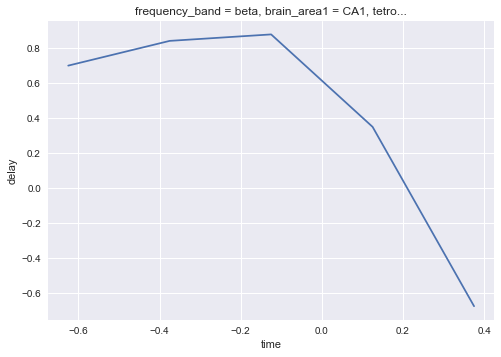

In [294]:
n_bands = len(FREQUENCY_BANDS)
delay, slope, r_value = (np.zeros((c.time.size, n_bands, m.n_signals, m.n_signals)),) * 3

for band_ind, frequency_band in enumerate(FREQUENCY_BANDS):
    (delay[:, band_ind, ...],
     slope[:, band_ind, ...],
     r_value[:, band_ind, ...]) = c.group_delay(
        FREQUENCY_BANDS[frequency_band], frequency_resolution=m.frequency_resolution)
    
coordinate_names = ['time', 'frequency_band', 'tetrode1', 'tetrode2']
ds = xr.Dataset(
    {'delay': (coordinate_names, delay),
     'slope': (coordinate_names, slope),
     'r_value': (coordinate_names, r_value)},
    coords={'time': c.time + np.diff(c.time)[0] / 2, 
            'frequency_band': list(FREQUENCY_BANDS.keys()),
            'tetrode1': tetrode_info.tetrode_id.values,
            'tetrode2': tetrode_info.tetrode_id.values,
            'brain_area1': ('tetrode1', tetrode_info.area.tolist()),
            'brain_area2': ('tetrode2', tetrode_info.area.tolist()),
            'session': np.array(['{0}_{1:02d}_{2:02d}'.format(*epoch_key)]),
            }
)

ds['delay'].sel(frequency_band='beta', tetrode1='HPa621', tetrode2='HPa622').plot();

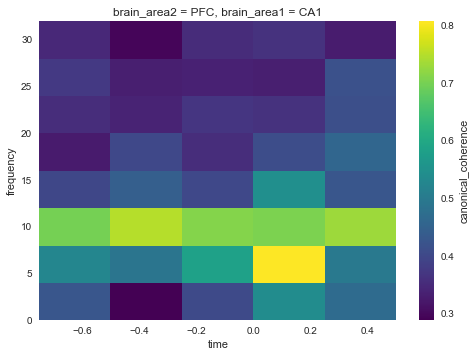

In [323]:
canonical_coherence, area_labels = c.canonical_coherence(tetrode_info.area.tolist())
dimension_names = ['time', 'frequency', 'brain_area1', 'brain_area2']
data_vars = {'canonical_coherence': (dimension_names, canonical_coherence)}
coordinates = {
    'time': c.time + np.diff(c.time)[0] / 2,
    'frequency': c.frequencies + np.diff(c.frequencies)[0] / 2,
    'brain_area1': area_labels,
    'brain_area2': area_labels,
    'session': np.array(['{0}_{1:02d}_{2:02d}'.format(*epoch_key)]),
}
ds = xr.Dataset(data_vars, coords=coordinates)

ds.sel(brain_area1='CA1', brain_area2='PFC', frequency=slice(0, 30)).canonical_coherence.plot(x='time', y='frequency')

In [353]:
from src.analysis import ripple_triggered_connectivity

for parameters_name, parameters in MULTITAPER_PARAMETERS.items():
    ripple_triggered_connectivity(
        lfps, epoch_key, tetrode_info, ripple_times, parameters,
        FREQUENCY_BANDS,
        multitaper_parameter_name=parameters_name,
        group_name='all_ripples')

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.25, time_window_step=0.25, detrend_type='constant', start_time=-0.75)
Maximum iterations reached. 0 of 5 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.5, time_window_step=0.5, detrend_type='constant', start_time=-1.0)
Maximum iterations reached. 0 of 3 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.1, time_window_step=0.1, detrend_type='constant', start_time=-0.5)
Maximum iterations reached. 0 of 10 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.05, time_window_step=0.05, detrend_type='constant', start_time=-0.45)
Maximum iterations reached. 0 of 19 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.02, time_window_step=0.02, detrend_type='constant', start_time=-0.42)
Maximum iterations reached. 0

<xarray.Dataset>
Dimensions:              (brain_area1: 3, brain_area2: 3, frequency: 375, session: 1, time: 3)
Coordinates:
  * brain_area2          (brain_area2) object 'CA1' 'PFC' 'iCA1'
  * session              (session) object 'HPa_06_02'
  * time                 (time) float64 -0.75 -0.25 0.25
  * frequency            (frequency) float64 1.0 3.0 5.0 7.0 9.0 11.0 13.0 ...
  * brain_area1          (brain_area1) object 'CA1' 'PFC' 'iCA1'
Data variables:
    canonical_coherence  (time, frequency, brain_area1, brain_area2) float64 nan ...


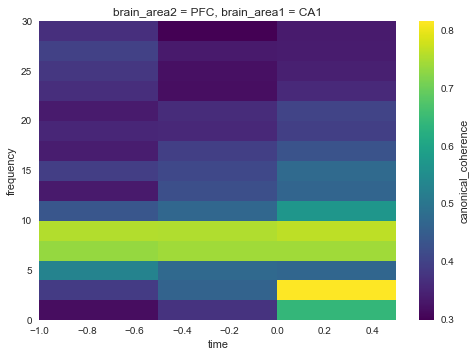

In [336]:
with xr.open_dataset(path, group='2Hz_Resolution/all_ripples/canonical_coherence') as da:
    da.load()
    print(da)
    da.sel(brain_area1='CA1', brain_area2='PFC', frequency=slice(0, 30)).canonical_coherence.plot(x='time', y='frequency')

<xarray.Dataset>
Dimensions:              (brain_area1: 3, brain_area2: 3, frequency: 75, session: 1, time: 10)
Coordinates:
  * brain_area2          (brain_area2) object 'CA1' 'PFC' 'iCA1'
  * session              (session) object 'HPa_06_02'
  * time                 (time) float64 -0.45 -0.35 -0.25 -0.15 -0.05 0.05 ...
  * frequency            (frequency) float64 5.0 15.0 25.0 35.0 45.0 55.0 ...
  * brain_area1          (brain_area1) object 'CA1' 'PFC' 'iCA1'
Data variables:
    canonical_coherence  (time, frequency, brain_area1, brain_area2) float64 nan ...


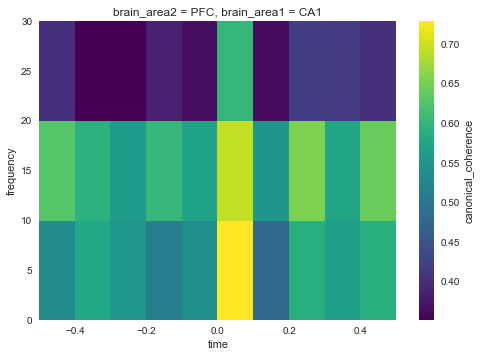

In [338]:
with xr.open_dataset(path, group='10Hz_Resolution/all_ripples/canonical_coherence') as da:
    da.load()
    print(da)
    da.sel(brain_area1='CA1', brain_area2='PFC', frequency=slice(0, 30)).canonical_coherence.plot(x='time', y='frequency')